Решим задачу классификации изображений микроскопа для определения расстояния z-стека. 
Готовые данные с известными расстояниями разделим на 41 класс:
* 0 - [-350; 350]
* все отрицательные классы равномерно разделены на 20 классов в диапазоне от -12500 до -350
* все положительные классы равномерно разделены на 20 классов в диапазоне от 350 до 12500


Для решения данной задачи воспользуемся готовой моделью сверточной нейронной сети для TransferLerning. В нашем случае это будет MobileNetV2.


Основной строительный блок этой сети в целом похож на предыдущее поколение, но имеет ряд ключевых особенностей.

Как и в MobileNetV1, здесь есть сверточные блоки с шагом 1 (на рисунке слева) и с шагом 2 (на рисунке справа). Блоки с шагом 2 предназначены для снижения пространственной размерности тензора и, в отличие от блока с шагом 1, не имеют residual connections.

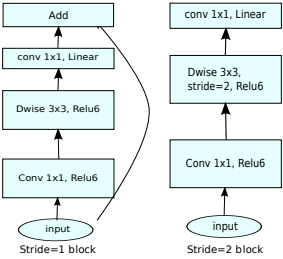

Сначала идёт pointwise convolution с большим количеством каналов, называемый expansion layer. 

На входе этот слой принимает тензор размерности $D_f * D_f * C_{in}$, а на выходе выдает тензор $D_f * D_f * (t*C_{in})$, где $t$ — новый гиперпараметр, названный уровнем расширения (в оригинале expansion factor). Авторы рекомендуют задавать этому гиперпараметру значение от 5 до 10, где меньшие значения лучше работают для более маленьких сетей, а большие — для более крупных (в самой статье во всех экспериментах принимается $t = 6$). 

Этот слой создает отображение входного тензора в пространстве большой размерности. Авторы называют такое отображение «целевым многообразием» (в оригинале «manifold of interest»)
Затем идёт depthwise convolution с ReLU6-активацией. Этот слой вместе с предыдущим по сути образует уже знакомый нам строительный блок MobileNetV1.

На входе этот слой принимает тензор размерности $D_f * D_f * (t*C_{in})$, а на выходе выдает тензор $(D_f/s) * (D_f/s) * (t*C_{in})$, где $s$ — шаг свертки (stride), ведь как мы помним, depthwise convolution не меняет число каналов.
В конце идёт 1х1-свертка с линейной функцией активации, понижающая число каналов. Авторы статьи выдвигают гипотезу, что «целевое многообразие» высокой размерности, полученное после предыдущих шагов, можно «уложить» в подпространство меньшей размерности без потери полезной информации, что, собственно и делается на этом шаге (как можно увидеть по экспериментальным результатам, эта гипотеза полностью оправдывается).

На входе такой слой принимает тензор размерности $(D_f/s) * (D_f/s) * (t*C_{in})$, а на выходе выдает тензор $(D_f/s) * (D_f/s) * C_{out}$, где $C_{out}$ — количество каналов на выходе блока.

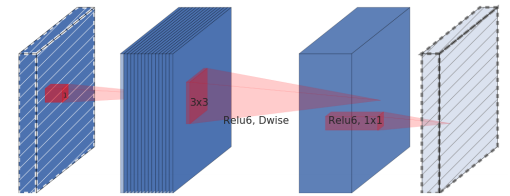

Фактически, именно третий слой в этом блоке, называемый bottleneck layer, и является основным отличием второго поколения MobileNet от первого.

Теперь, когда мы знаем, как MobileNet устроен внутри, давайте посмотрим, насколько хорошо он работает.

Результаты работы MobileNetV2 по сравнению с другими моделями
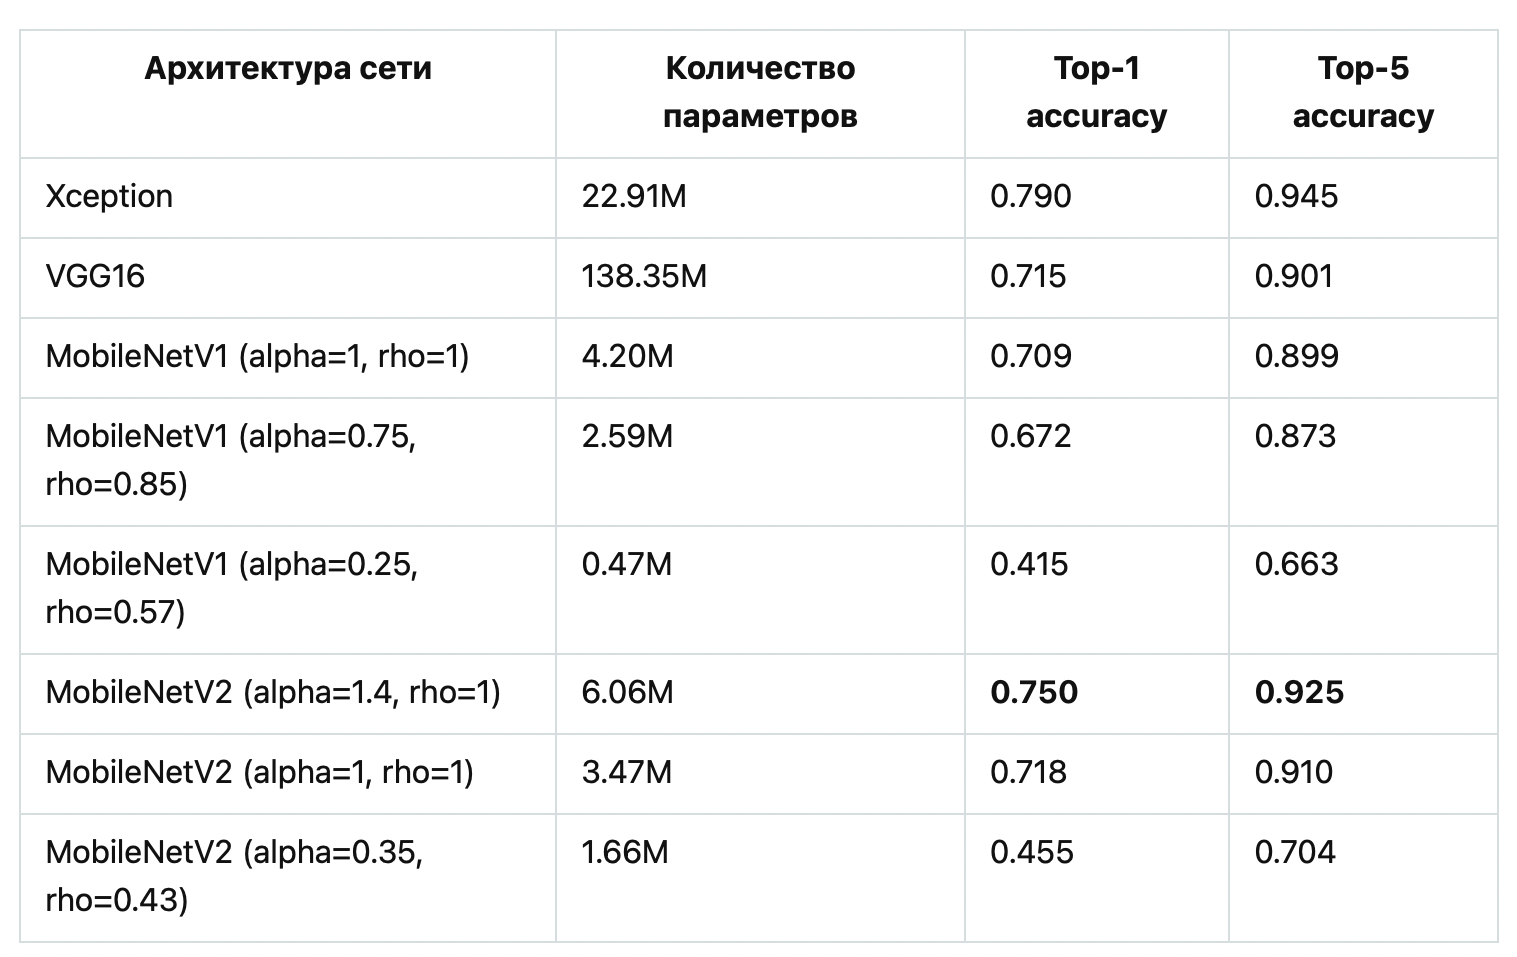



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
import numpy as np
import pandas as pd

In [ ]:
FINE_TUNING_EPOCHS = 5
TRAINING_EPOCHS = 15

image_height = 224 
image_width = 224

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive

<module 'google.colab.drive' from '/usr/local/lib/python3.9/dist-packages/google/colab/drive.py'>

In [ ]:
%cd /content/drive/MyDrive/classes_split

/content/drive/.shortcut-targets-by-id/15NDkbRA_zToSnWwp6dew2PR6SI-d4WHG/classes_split


In [ ]:
 df = pd.read_excel('image database_1.xlsx', index_col = 0)

In [ ]:
main_path = '/content/drive/MyDrive/classes_split'

In [ ]:
df

,defocus,class_range,data set,path
file,,,,
Seg11_defocus-450.jpg,-450,class -1,test,test//class -1//Seg11_defocus-450.jpg
Seg11_defocus-550.jpg,-550,class -1,test,test//class -1//Seg11_defocus-550.jpg
Seg11_defocus-750.jpg,-750,class -1,test,test//class -1//Seg11_defocus-750.jpg
Seg12_defocus-700.jpg,-700,class -1,test,test//class -1//Seg12_defocus-700.jpg
Seg13_defocus-800.jpg,-800,class -1,test,test//class -1//Seg13_defocus-800.jpg
...,...,...,...,...
Seg7_defocus4900.jpg,4900,class 9,val,val//class 9//Seg7_defocus4900.jpg
Seg7_defocus5000.jpg,5000,class 9,val,val//class 9//Seg7_defocus5000.jpg
Seg8_defocus5300.jpg,5300,class 9,val,val//class 9//Seg8_defocus5300.jpg


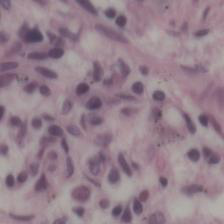

In [ ]:
import PIL
PIL.Image.open('test//class -1//Seg11_defocus-450.jpg')

In [ ]:
freq = df['class_range'].value_counts()
print(freq)

class 0      394
class -5     292
class 8      292
class 6      292
class -13    292
class 3      292
class -15    292
class 16     292
class 13     292
class 11     292
class 1      292
class -10    292
class -8     292
class -3     292
class -7     290
class 9      290
class -17    290
class -1     289
class -11    289
class 5      289
class 15     289
class 10     288
class -6     288
class -16    288
class 12     287
class -12    287
class 4      287
class -14    287
class 2      287
class -4     287
class -2     287
class 14     287
class -18    285
class -9     284
class 7      284
class 17     281
class 18     263
class -19    253
class -20    187
class 19     161
class 20      22
Name: class_range, dtype: int64


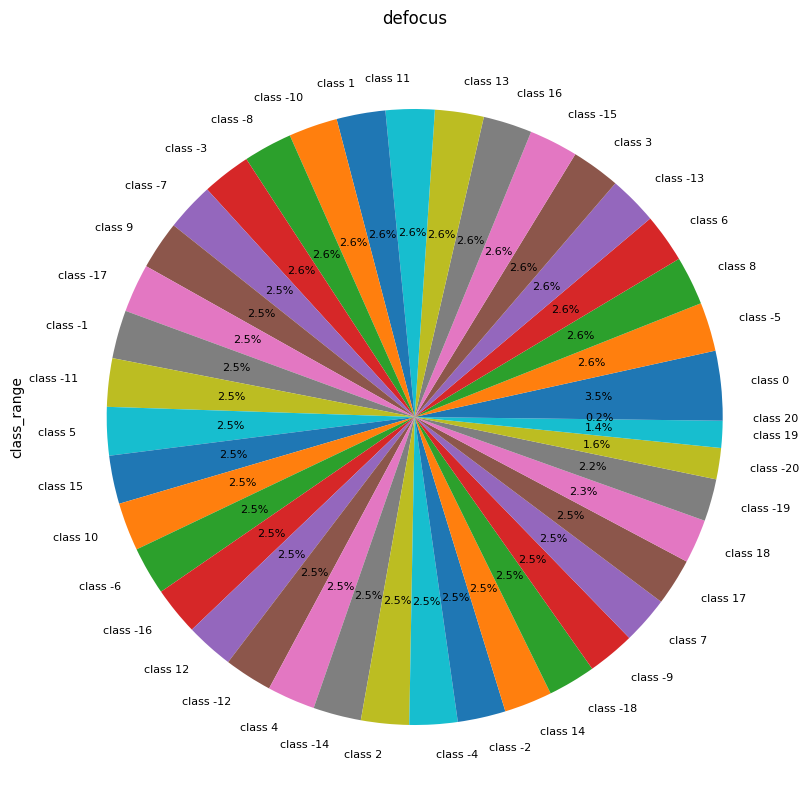

In [ ]:
freq.plot(kind='pie',figsize=(10,10),title='defocus',autopct='%1.1f%%',shadow = False,  fontsize=8);

In [ ]:
freq = df['data set'].value_counts()
print(freq)


train    6825
test     2310
val      2261
Name: data set, dtype: int64


In [ ]:
train_df = df[df['data set']== 'train']
valid_df = df[df['data set']== 'val']
test_df  = df[df['data set']== 'test']

In [ ]:
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)

train_generator = gen.flow_from_dataframe(
    train_df, # dataframe
    directory = main_path,
    x_col = 'path',
    y_col = 'class_range',
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = batch_size,
    shuffle = True,
    seed = 42)

Found 6308 validated image filenames belonging to 41 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 517 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_gen.flow_from_dataframe(
    test_df, # dataframe
    directory   = main_path, # images data path / folder in which images are there
    x_col       = 'path',
    y_col       = 'class_range',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = batch_size,
    shuffle  = False)

Found 2310 validated image filenames belonging to 41 classes.


In [ ]:
validation_generator = test_gen.flow_from_dataframe(
    valid_df, # dataframe
    directory   = main_path, # images data path / folder in which images are there
    x_col       = 'path',
    y_col       = 'class_range',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = batch_size,
    shuffle     = True,
    seed        = 42)

Found 2241 validated image filenames belonging to 41 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 20 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
a = train_generator.class_indices
class_names = list(a.keys())

In [ ]:
class_names

['class -1',
 'class -10',
 'class -11',
 'class -12',
 'class -13',
 'class -14',
 'class -15',
 'class -16',
 'class -17',
 'class -18',
 'class -19',
 'class -2',
 'class -20',
 'class -3',
 'class -4',
 'class -5',
 'class -6',
 'class -7',
 'class -8',
 'class -9',
 'class 0',
 'class 1',
 'class 10',
 'class 11',
 'class 12',
 'class 13',
 'class 14',
 'class 15',
 'class 16',
 'class 17',
 'class 18',
 'class 19',
 'class 2',
 'class 20',
 'class 3',
 'class 4',
 'class 5',
 'class 6',
 'class 7',
 'class 8',
 'class 9']

In [ ]:
import matplotlib.pyplot as plt

def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[8, 14])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])]) 

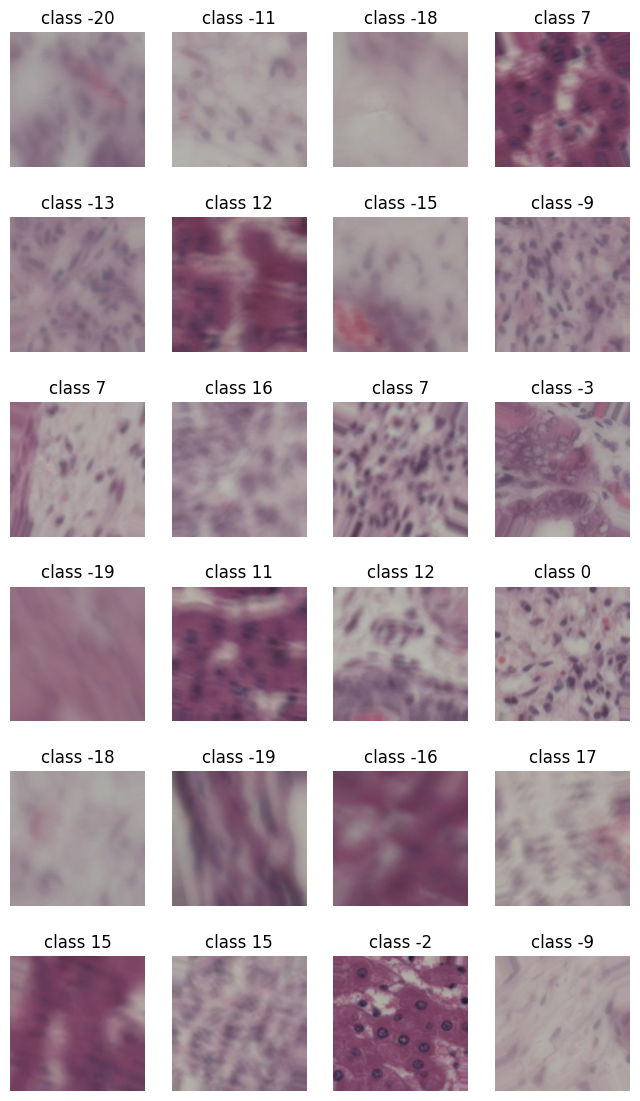

In [ ]:
x,y = next(train_generator)
plot_images(x,y)

In [ ]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

     # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
from tensorflow.keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    model = Model(base_model.inputs, outputs)
    
    return model  


In [ ]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False 
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])   
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])
    
    return history

In [ ]:
# load the VGG16 architecture with imagenet weights as base
vgg16_base_model = tf.keras.applications.MobileNetV2(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )
vgg16_model = create_model(vgg16_base_model)
#vgg16_model.summary()
history = fit_model(vgg16_model, vgg16_base_model, epochs = TRAINING_EPOCHS)

9406464/9406464 [==============================] - 0s 0us/step
Unfreezing number of layers in base model =  0
Epoch 1/15
198/198 [==============================] - 1547s 8s/step - loss: 2.8571 - accuracy: 0.1321 - val_loss: 2.2406 - val_accuracy: 0.2213
Epoch 2/15
198/198 [==============================] - 95s 481ms/step - loss: 2.2068 - accuracy: 0.2154 - val_loss: 1.9952 - val_accuracy: 0.2584
Epoch 3/15
198/198 [==============================] - 99s 500ms/step - loss: 1.9876 - accuracy: 0.2522 - val_loss: 1.8023 - val_accuracy: 0.2816
Epoch 4/15
198/198 [==============================] - 96s 484ms/step - loss: 1.8822 - accuracy: 0.2724 - val_loss: 1.7591 - val_accuracy: 0.2994
Epoch 5/15
198/198 [==============================] - 100s 506ms/step - loss: 1.7979 - accuracy: 0.2915 - val_loss: 1.7404 - val_accuracy: 0.3052
Epoch 6/15
198/198 [==============================] - 96s 483ms/step - loss: 1.7418 - accuracy: 0.3134 - val_loss: 1.6896 - val_accuracy: 0.3159
Epoch 7/15
198/198 [

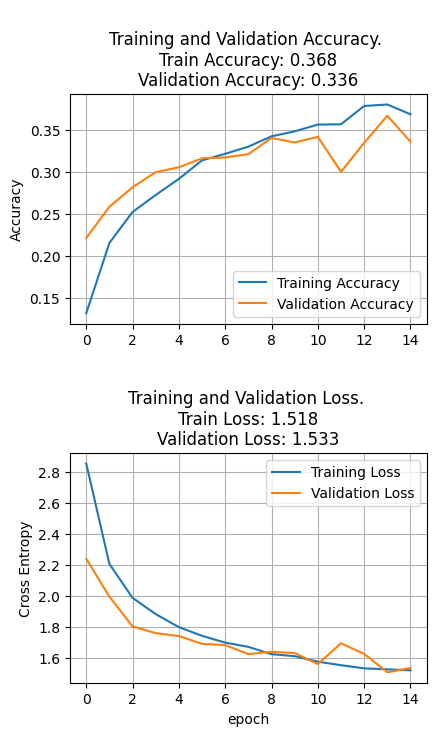

In [ ]:
plot_history(history)

In [ ]:
accuracy_score = vgg16_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

71/71 [==============================] - 13s 174ms/step - loss: 1.5333 - accuracy: 0.3356
[1.533264398574829, 0.3355644941329956]
Accuracy: 33.56%
Loss: 1.533


In [ ]:
test_generator.reset()

vgg16_test_preds = vgg16_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg16_test_preds, axis=1)

73/73 [==============================] - 421s 6s/step


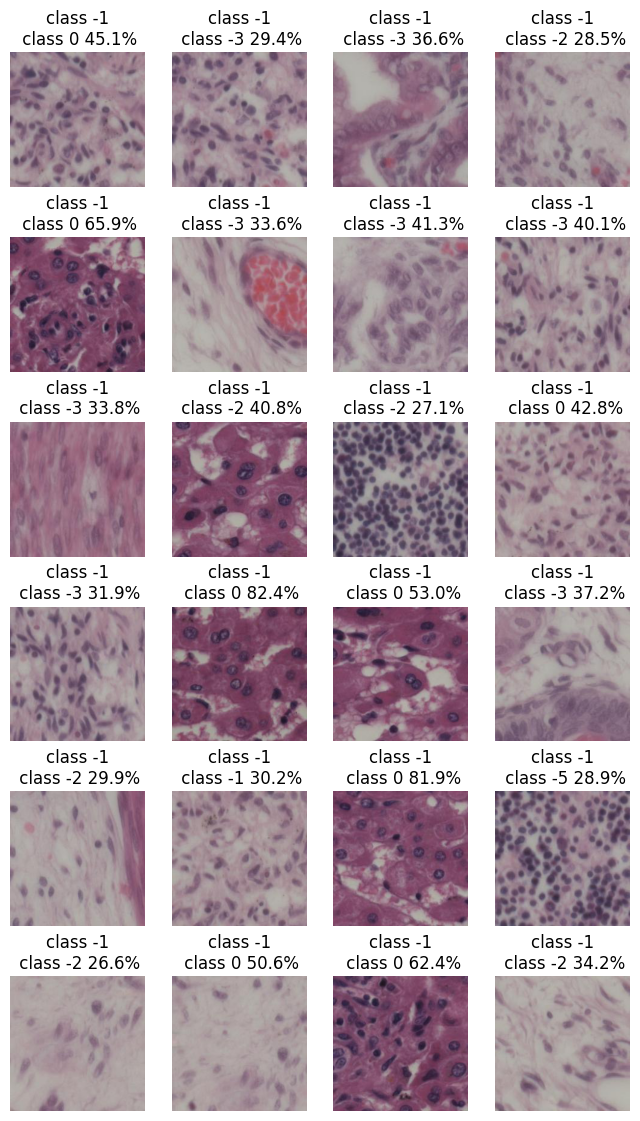

In [ ]:
test_generator.reset()
x,y = next(test_generator)
plot_images(x, y, vgg16_test_preds)

Выводы по исследованию.

Во время решения задачи классификации изображений микроскопа с разным разным расстоянием z-стека была получена точность 33,56%, что довольно маленькое значение. Также стоит отметить, что самая точная классификация у класса 0, когда изображение находится в фокусе. Можно сделать несколько выводов для дальнейших исследований:
1. Разбить на меньшее количество классов (вместо 41 возможно 21 или даже меньше)
2. Попробовать другую модель для задачи классификации
3. Взять либо только положительные, либо только отрицательные классы